# Classifying different species of birds using ResNet

## Setup

In [ ]:
import sys
PATH = '<add path>'
sys.path.append(PATH)

%cd $PATH

Mounted at /content/drive
/content/drive/My Drive/project


In [ ]:
# Math/deep learning libraries
import numpy as np
import torch
from torch import nn

# Data processing
import pandas as pd

# Data transformations
import torchvision

# Provided utils
import utils

# Loading images/bundles of images
from PIL import Image
import h5py

# Plotting
import matplotlib.pyplot as plt

# Progress bars
import tqdm

# Other
import time
from datetime import date

In [ ]:
# Set PyTorch to use the GPU
device = torch.device('cuda')

In [ ]:
# set random seed
torch.manual_seed(7)

## Dataset

### Loading images from a bundle

In [ ]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.images = []
        self.labels = []
        self.classes = []
        self.transform = transform

        self.images, self.labels, self.classes = utils.load_data()
        
        assert len(self.images) == len(self.labels)
    
    def __len__(self):
        """Returns the number of examples in the dataset"""
        return len(self.images)
    
    def num_classes(self):
        """Returns the number of classes in the dataset"""
        uniqueClasses = []
        for i in range(len(self.classes)):
          if self.classes[i] not in uniqueClasses:
            uniqueClasses.append(self.classes[i])
        return len(uniqueClasses)
    
    def get_class(self, label):
        """Returns the name of the bird corresponding to the given label value"""
        uniqueLabels = []
        for i in range(len(self.labels)):
          if self.labels[i] == label:
            break
          elif self.labels[i] not in uniqueLabels:
            uniqueLabels.append(self.labels[i])
            
        index = len(uniqueLabels)
        return self.classes[index]

    def get_image(self, idx):
        """Returns the image of the idx'th example in the dataset"""
        return self.images[idx]

    def get_label(self, idx):
        """Returns the label of the idx'th example in the dataset"""
        return self.labels[idx]
    
    def __getitem__(self, idx):
        """Returns a tuple of the *transformed* image and label of the idx'th example in the dataset"""
        image = self.images[idx]
        transformedImage = self.transform(image)
        label = self.labels[idx]  
        return (transformedImage, label)
    
    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

## Creating and visualizing the dataset

In [ ]:
from torchvision import transforms

transform = transforms.Compose([torchvision.transforms.ToTensor(),])
all_data = BirdDataset(transform = transform)

### Visualizing the data

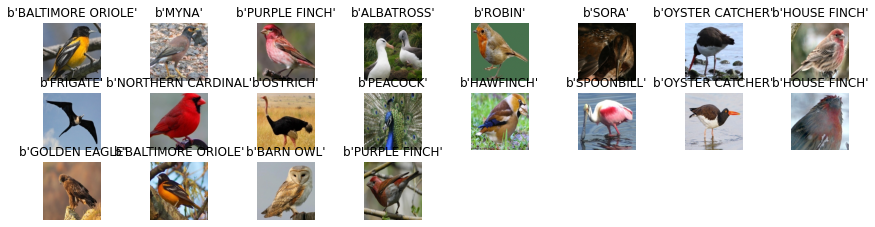

In [ ]:
# Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 8
num_cols = 8
for plot_idx in range(20):
    ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
    idx = (plot_idx * 373) % len(all_data)  # Gets a "random" index in the dataset

    # for this code, use `idx` as the dataset index
    cur_image = all_data.get_image(idx) 
    cur_label = all_data.get_label(idx) 
    cur_class = all_data.get_class(cur_label) 

    ax.title.set_text(cur_class)
    plt.axis('off')
    plt.imshow(cur_image)

## Model structure

ResNet Citation:
Nouman (2022) Writing ResNet from Scratch in PyTorch https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 20):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(p=0.2)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BirdModel(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        # input = 224 x 224 x 3
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128 * 27 * 27, 100)
        self.fc2 = nn.Linear(100, num_classes)
        self.dropout = nn.Dropout(p=0.4)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(128)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.batchnorm3(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.batchnorm4(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 27 * 27)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
image = all_data[0][0].unsqueeze(0).float()
model = BirdModel()
model(image)


tensor([[ 0.5178,  0.8379,  0.4336, -0.2507,  1.0543, -0.6312,  0.1219, -0.4374,
         -0.3800, -0.1243,  0.4606, -0.1673,  0.0273,  0.4654, -0.3632,  0.3509,
          0.1124,  0.6032,  0.1612, -0.2056]], grad_fn=<AddmmBackward0>)

In [ ]:
image = all_data[0][0].unsqueeze(0).float()
model2 = ResNet(ResidualBlock, [3, 3, 6, 3])
model2(image)

tensor([[ 0.3318,  0.2956,  0.1140,  0.8707,  1.3301, -0.7904, -0.3512,  0.3039,
          0.1365,  0.5317,  0.1694,  0.1429, -0.0245, -0.3801, -0.1640, -0.1705,
         -0.2592,  0.3829,  0.6876, -0.6146]], grad_fn=<AddmmBackward0>)

## Training setup

### Hyperparameters

In [ ]:
batch_size = 32 
learning_rate = .001 
num_epochs = 30

### Data Augmentation

In [ ]:
aug = torchvision.transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  #mirrors the image
    transforms.RandomRotation(30)])
## we ended up not using image augmentation as it worsened model performance

### Data loaders

In [ ]:
total_len = all_data.__len__()
train_len = round(0.8 * total_len)
val_len = total_len - train_len
print(train_len, val_len)

train_set, val_set = torch.utils.data.random_split(all_data,[train_len, val_len],
                                                   generator = torch.Generator().manual_seed(51))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)


2490 623


## Training

### Evaluation function

In [ ]:
# split is a variable you can set as the "name" of the dataset (either "train" or "val")
def evaluate(model, data_loader, name="val"):
    correct = 0  # number of correct predictions
    total = 0    # total number of examples in the data loader

    with torch.no_grad():
      for images, labels in data_loader:
        images = images.float()
        outputs = model(images.to(device=device))
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()   # Move to cpu to be compared with labels, which are on cpu
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {total} {name} images: {accuracy :.2f}%')
    return accuracy

### Training loop

Training Loop for ResNet

In [ ]:
# TRAINING LOOP FOR RESNET

import torch.optim as optim
model = ResNet(ResidualBlock, [3, 3, 6, 3])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
last_accuracy = 0
patience = 3
trigger = 0
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    inputs = inputs.float()

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    if torch.cuda.is_available():
      model.cuda()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  
  print ('Epoch [{}/{}], Loss: {:.2f}' .format(epoch+1, num_epochs, loss.item()))
  evaluate(model, train_loader, name='train')
  val_accuracy = evaluate(model, val_loader, name='val')
  
  # early stopping: if validation accuracy keeps dropping, stop the overfitting
  if (last_accuracy > val_accuracy):
    trigger += 1
    if trigger == patience:
      break
  else:
    trigger = 0
    last_accuracy = val_accuracy

print('Finished Training')

end_time = time.time()
print(f"Total training time: {end_time - start_time} sec")

Epoch [1/30], Loss: 1.76
Accuracy of the network on the 2490 train images: 29.88%
Accuracy of the network on the 623 val images: 29.37%
Epoch [2/30], Loss: 1.82
Accuracy of the network on the 2490 train images: 36.02%
Accuracy of the network on the 623 val images: 37.24%
Epoch [3/30], Loss: 1.73
Accuracy of the network on the 2490 train images: 44.26%
Accuracy of the network on the 623 val images: 41.57%
Epoch [4/30], Loss: 1.16
Accuracy of the network on the 2490 train images: 50.28%
Accuracy of the network on the 623 val images: 45.43%
Epoch [5/30], Loss: 1.14
Accuracy of the network on the 2490 train images: 58.88%
Accuracy of the network on the 623 val images: 58.27%
Epoch [6/30], Loss: 0.89
Accuracy of the network on the 2490 train images: 66.59%
Accuracy of the network on the 623 val images: 64.04%
Epoch [7/30], Loss: 0.89
Accuracy of the network on the 2490 train images: 73.45%
Accuracy of the network on the 623 val images: 69.34%
Epoch [8/30], Loss: 1.69
Accuracy of the network

In [ ]:
## RESULTS FOR RESNET
evaluate(model, train_loader, name='train')
evaluate(model, val_loader, name='val')
print("")

Accuracy of the network on the 2490 train images: 96.67%
Accuracy of the network on the 623 val images: 81.06%



Training Loop for CNN

In [ ]:
# TRAINING LOOP FOR CNN

import torch.optim as optima
model = BirdModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()
last_accuracy = 0
patience = 3
trigger = 0
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    inputs = inputs.float()

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    if torch.cuda.is_available():
      model.cuda()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  
  print ('Epoch [{}/{}], Loss: {:.2f}' .format(epoch+1, num_epochs, loss.item()))
  evaluate(model, train_loader, name='train')
  val_accuracy = evaluate(model, val_loader, name='val')

  # early stopping: if validation accuracy keeps dropping, stop the overfitting
  if (last_accuracy > val_accuracy):
    trigger += 1
    if trigger == patience:
      break
  else:
    trigger = 0
    last_accuracy = val_accuracy

print('Finished Training')

end_time = time.time()
print(f"Total training time: {end_time - start_time} sec")

Epoch [1/100], Loss: 3.46
Accuracy of the network on the 2490 train images: 30.40%
Accuracy of the network on the 623 val images: 25.68%
Epoch [2/100], Loss: 2.20
Accuracy of the network on the 2490 train images: 38.88%
Accuracy of the network on the 623 val images: 30.82%
Epoch [3/100], Loss: 2.05
Accuracy of the network on the 2490 train images: 49.08%
Accuracy of the network on the 623 val images: 39.81%
Epoch [4/100], Loss: 1.69
Accuracy of the network on the 2490 train images: 52.25%
Accuracy of the network on the 623 val images: 42.70%
Epoch [5/100], Loss: 1.37
Accuracy of the network on the 2490 train images: 56.83%
Accuracy of the network on the 623 val images: 46.39%
Epoch [6/100], Loss: 1.53
Accuracy of the network on the 2490 train images: 61.85%
Accuracy of the network on the 623 val images: 49.92%
Epoch [7/100], Loss: 1.01
Accuracy of the network on the 2490 train images: 65.38%
Accuracy of the network on the 623 val images: 51.69%
Epoch [8/100], Loss: 0.92
Accuracy of the

In [ ]:
## RESULTS FOR CNN
evaluate(model, train_loader, name='train')
evaluate(model, val_loader, name='val')
print("")

Accuracy of the network on the 2490 train images: 69.72%
Accuracy of the network on the 623 val images: 50.40%



### Saving model weights

In [ ]:
model_name = "ResnetTest"  ### CHANGE THIS NAME EACH TIME YOU SAVE WEIGHTS! ###

date_str = date.today().strftime("%Y_%m_%d")
model_weights_filename = f"{date_str}_{model_name}.pt"

torch.save(model.state_dict(), f"{model_weights_filename}")
print(f"Model weights saved as {model_weights_filename}")

Model weights saved as 2022_11_28_ResnetTest.pt


## Predict functions

In [ ]:
def load_model():
    # model_path = model_weights_filename
    model_path = '2022_11_28_ResnetTest.pt'
    model = ResNet(ResidualBlock, [3, 3, 6, 3])
    model.load_state_dict(torch.load(model_path))
    return model

In [ ]:
def predict(model, image_path):
    model = model.to(device = device)
    prediction = None
   
    image = Image.open(image_path)
    transform = transforms.Compose([torchvision.transforms.ToTensor(),])
    image = transform(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
      
      output = model(image.to(device=device))
      _, predicted = torch.max(output.data, 1)
      predicted = predicted.cpu().item()   # Move to cpu to be compared with labels, which are on cpu

    return predicted

In [ ]:
Model = load_model()

In [ ]:
predict(Model, 'bird_data/0 - BALTIMORE ORIOLE/0_100.jpg')

16